In [29]:
import numpy as np

dataset_index = 20
dataset = {}
with np.load("Kinect%d.npz"%dataset_index) as data:
    print("The keys of Kinect data are: %s" % (list(data.keys())))
    dataset['disp_stamps'] = data["disparity_time_stamps"] # acquisition times of the disparity images
    print("The shape of disp_stamps is: %s" % (dataset['disp_stamps'].shape,))

    dataset['rgb_stamps'] = data["rgb_time_stamps"] # acquisition times of the rgb images
    print("The shape of rgb_stamps is: %s" % (dataset['rgb_stamps'].shape,))

The keys of Kinect data are: ['disparity_time_stamps', 'rgb_time_stamps']
The shape of disp_stamps is: (2407,)
The shape of rgb_stamps is: (2289,)


In [30]:
def correlate_timestamp(t1, t2):
    """
    Return an array of timestamps. Here we assume that t2 will be used for ground-truth correlation, and that t2 has
    smaller lengths than t1. 
    """
    t2_start_index = 0; 
    t1_index = 0

    # First roll depth_timestamp pointer to the first timestamp that is later than the first rgb reading. 
    for i in range(t2.shape[0]):
        if t1[0] < t2[i]:
            t2_start_index = i
            break
            
    # depth_timestamp = depth_timestamp[depth_start_index:]
    correlated_timestamp = np.zeros((2, t2.shape[0] - t2_start_index + 1)).astype(int)
    print("T2 start index is: %s" % t2_start_index)
    
    for j in range(correlated_timestamp.shape[1] - 1):
        
        # reach the end of t1;
        if t1_index >= t1.shape[0]:
            break
        while t1_index + 1 < t1.shape[0] and \
         t1[t1_index + 1] < t2[j + t2_start_index]:
            t1_index += 1
        correlated_timestamp[:, j] = np.array([t1_index, j + t2_start_index]) 
            # Use the most recent one for correlation;
        
    print("The shape of correlated_timestamp is: %s" % (correlated_timestamp.shape,))
    print("The first 5 entries are: %s" % (correlated_timestamp[:, 0:5],))
    return correlated_timestamp
            
correlated_timestamp = correlate_timestamp(dataset['rgb_stamps'], dataset['disp_stamps'])

T2 start index is: 1
The shape of correlated_timestamp is: (2, 2407)
The first 5 entries are: [[0 2 3 4 5]
 [1 2 3 4 5]]


In [51]:

def transform_from_d(d_image):
    """
    Obtain the depth, and the location(i,j) of the corresponding pixels;
    d_image: m x n image of depth values
    """
    dd = -0.00304 * d_image + 3.31
    depth = 1.03 / dd
    
    i_matrix = np.tile(np.arange(0, d_image.shape[1], 1), (d_image.shape[0], 1)).astype(int)
    j_matrix = np.tile(np.expand_dims(np.arange(0, d_image.shape[0], 1), axis = 1), (1, d_image.shape[1])).astype(int)
    
    rgbi = np.round((i_matrix * 526.37 + dd * (-4.5 * 1750.46) + 19276.0)/585.051).astype(int)
    rgbj = np.round((j_matrix * 526.37 + 16662.0) / 585.051).astype(int)
    
    return (rgbi, rgbj, depth)

Reading depth image file: ./dataRGBD/Disparity20/disparity20_3.png
Reading rgb image file: ./dataRGBD/RGB20/rgb20_1.png


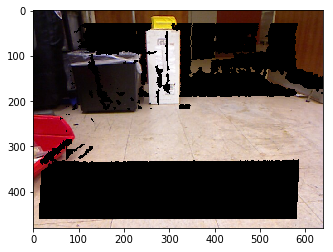

In [59]:
import matplotlib.pyplot as plt
from PIL import Image

depth_images_prefix = './dataRGBD/Disparity%s/disparity%s_' % (dataset_index, dataset_index)
rgb_images_prefix = './dataRGBD/RGB%s/rgb%s_' % (dataset_index, dataset_index)

for i in range(1):
    depth_img_file = depth_images_prefix + str(correlated_timestamp[i, 1] + 1) + ".png"
    rgb_img_file = rgb_images_prefix + str(correlated_timestamp[i, 0] + 1) + ".png"
    
    print("Reading depth image file: %s" % depth_img_file)
    print("Reading rgb image file: %s" % rgb_img_file)
    depth_img = Image.open(depth_img_file)
    disparity_img = np.array(depth_img.getdata(),np.uint16).reshape(depth_img.size[1], depth_img.size[0])
    # print("The range of disparities are: %s" % np.unique(disparity_img))
    rgb_img = Image.open(rgb_img_file)
    rgb_img = np.array(rgb_img.getdata(), np.uint8).reshape(rgb_img.size[1], rgb_img.size[0], 3)
    
    rgbi, rgbj, depth = transform_from_d(disparity_img)
    
    # print("The range of depth in the image is: %s" % (np.unique(depth, return_counts = True),))
    
    # mask pixels that are out of range
    # invalid_pixels = np.logical_or.reduce((depth < 1, depth > 2, rgbi < 0, rgbi >= 640, rgbj < 0, rgbj >= 480))
    invalid_pixels = np.logical_or(depth < 1, depth > 2)
    invalid_pixels = np.logical_and.reduce((invalid_pixels, rgbi >= 0, rgbi < 640, rgbj >= 0, rgbj < 480))
    
    rgb_img[rgbj[invalid_pixels], rgbi[invalid_pixels], :] = 0 
    
    # print("The shape of masked pixels are: %s" % (masked_pixels.shape,) )
    plt.imshow(rgb_img)
    plt.show()

In [84]:
import numpy.linalg as linalg
import math

def to_homogenuous(coords_euclid):
  return np.append(coords_euclid, np.ones((1,1)), axis = 0);

def from_homog(coordinate):
	return coordinate[:-1] / coordinate[-1]

roll = 0
pitch = 0.36
yaw = 0.021

f_su=585.05108211 
f_sv=585.05108211
f_s_theta =0
cu=242.94140713
cv=315.83800193


K = np.array([[f_su, f_s_theta, cu], [0, f_sv, cv], [0, 0, 1]])
projection_matrix = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]])

K_inv = linalg.inv(K)
# projection_matrix_inv = linalg.inv(projection_matrix)

R_c_to_o = np.array([[0, -1, 0],
                     [0, 0, -1],
                     [1, 0, 0]])

R_x = np.array([[1,0,0],
                [0, math.cos(roll), -math.sin(roll)],
                [0, math.sin(roll), math.cos(roll)]])

R_y = np.array([[math.cos(pitch), 0, math.sin(pitch)],
                [0, 1, 0],
                [-math.sin(pitch), 0, math.cos(pitch)]])

R_z = np.array([[math.cos(yaw), -math.sin(yaw), 0],
                [math.sin(yaw), math.cos(yaw), 0],
                [0, 0, 1]])

R_c_to_b = R_z.dot(R_y.dot(R_x))


p_c_to_b = np.array([[0.18], [0.005], [0.36]])

pose_c_b = np.identity(4)
pose_c_b[0:3, 0:3] = R_c_to_o.dot(R_c_to_b.T)
pose_c_b[0:3, -1] = -R_c_to_o.dot(R_c_to_b.T).dot(p_c_to_b).reshape(3)

p_c = to_homogenuous(p_c_to_b)

pose_c_b_inv = linalg.inv(pose_c_b)

def tranform_from_2D_to_3D(coordinate, depth):
    """
    Coordinate is a 3 x 1 in homogeneuous coordinate
    """
    c_euclid = from_homog(coordinate)
    c_3D = np.ones((3,1)) # 3 x 1 array
    c_3D[0:2, :] = c_euclid
    c_3D = depth * c_3D
    return to_homogenuous(c_3D)


def transform_from_camera_to_body_frame(coordinate, depth):
    """
    Coordinate is a 2 x 1 in euclidean coordinate
    """
    c_h = to_homogenuous(coordinate)
    return pose_c_b_inv.dot(tranform_from_2D_to_3D(K_inv.dot(c_h), depth))

coordinate = np.array([[320],[240]]) # middle of the image frame
depth = 0
p_b = from_homog(transform_from_camera_to_body_frame(coordinate, depth))
print(p_b)
    

[[0.18 ]
 [0.005]
 [0.36 ]]


In [ ]:

def map_rgb_coordinates_to_world_grid(rgb_img, rgbi, rgbj, depth, robot_pos):
    """
    Transform the pixels values RGB to the world coordinate frame;
    """